# Calibrate a LISFLOOD reservoir
***

**Autor:** Chus Casado<br>
**Date:** 31-10-2023<br>



In [ ]:
# -*- coding: utf-8 -*-
"""
Copyright 2015 by Tobias Houska
This file is part of Statistical Parameter Estimation Tool (SPOTPY).

:author: Tobias Houska

This class holds example code how to use the dream algorithm
"""

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import spotpy
from spotpy.objectivefunctions import kge

from spot_setup_burek import spot_setup
from reservoirs.reservoirs import Lisflood

## Configuration

In [2]:
ResID = 146

In [7]:
# sequential mode
parallel = "seq"  

# input file
input_file = f'reservoirs/input_{ResID:03}.csv'

# output file
output_file = 'reservoirs/SCEUA_burek'

# calibration period
start, end = datetime(2000, 1, 1), datetime(2019, 12, 31)

### Reservoir

In [8]:
# storage limits
Vc, Vn, Vf, Vtot = 109 * 1e6, 730.3 * 1e6, 1057.3 * 1e6, 1090 * 1e6
# outflow limits
Qmin, Qn, Qnd = 2.1, 14.3, 77.9

In [9]:
# parameters GloFAS
alpha_glofas, beta_glofas = 0.01, 1.59126

In [10]:
Vn_adj = Vn + alpha_glofas * (Vf - Vn)
Qn_adj = max(Qmin, min(Qn * beta_glofas, Qnd))

reservoir = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn_adj, Qnd)

In [20]:
sim = reservoir.simulate(data.inflow, data.storage[0], k=1.2)
kge(data.outflow, sim.outflow, return_all=True)

(0.686154778835329, 0.7258592765734516, 1.0924697505702703, 1.1216348298660457)

### Time series

In [11]:
# time series
data = pd.read_csv(input_file, sep=',', parse_dates=True, dayfirst=False, index_col='date')
# data.storage *= Vtot

train = data.loc[start:end]
test = data.loc[:start]

## Calibration
### Setup

In [12]:
# initialize the calibration setup of the LISFLOOD reservoir routine
setup = spot_setup(train.inflow, train.storage[0], train.outflow,
                        Vc, Vn, Vf, Vtot,
                        Qmin, Qn, Qnd,
                        spotpy.objectivefunctions.kge)

In [ ]:
from spotpy.parameter import Uniform

In [13]:
# Select number of maximum allowed repetitions
max_iter = 2000
sampler = spotpy.algorithms.sceua(setup, dbname="SCEUA_burek", dbformat="csv", save_sim=False)

### Launch

In [14]:
# Start the sampler, one can specify ngs, kstop, peps and pcento id desired
sampler.sample(max_iter, ngs=7, kstop=10, peps=0.1, pcento=0.01)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  2000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'SCEUA_burek.csv' created.
4 of 2000, minimal objective function=0.656103, time remaining: 00:13:55
8 of 2000, minimal objective function=0.656103, time remaining: 00:15:32
12 of 2000, minimal objective function=0.646377, time remaining: 00:16:10
16 of 2000, minimal objective function=0.646377, time remaining: 00:16:23
20 of 2000, minimal objective function=0.646377, time remaining: 00:16:35
24 of 2000, minimal objective function=0.646377, time remaining: 00:16:35
28 of 2000, minimal objective function=0.646377, time remaining: 00:16:45
32 of 2000, minimal objective function=0.646377, time remaining: 00:16:44
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
43 of 2000, minimal objective function=0.

### Analyse results 

In [15]:
# Load the results gained with the sceua sampler, stored in SCEUA_hymod.csv
# results = spotpy.analyser.load_csv_results("SCEUA_burek")
results = pd.read_csv('SCEUA_burek.csv')
results.columns = ['KGE', 'alpha', 'beta', 'chain']
results.KGE = 1 - results.KGE
results.index.name = 'iteration'

In [16]:
best_iter = results.KGE.idxmax()
best_of = results.loc[best_iter, 'KGE']
alpha, beta = results.loc[best_iter, ['alpha', 'beta']]
print(f'iteration {best_iter} got the highest performance:\tKGE = {best_of:.3f}')
print('best parameters:\nalpha = {0:.3f}\nbeta  = {1:.3f}'.format(alpha, beta))

iteration 284 got the highest performance:	KGE = 0.358
best parameters:
alpha = 0.016
beta  = 1.998


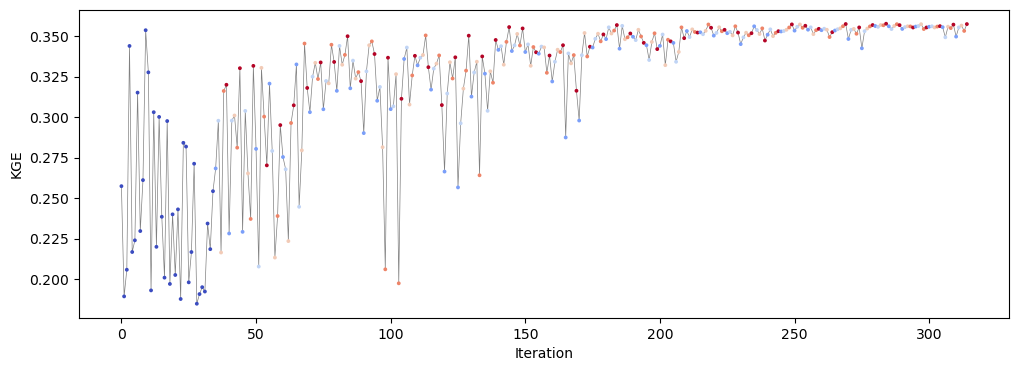

In [17]:
# Plot how the objective function was minimized during sampling
fig = plt.figure(figsize=(12, 4))
plt.plot(results.KGE, c='gray', lw=.5, zorder=0)
plt.scatter(results.index, results.KGE, c=results.chain, cmap='coolwarm', zorder=2, s=3)
plt.ylabel("KGE")
plt.xlabel("Iteration");
# fig.savefig("SCEUA_objectivefunctiontrace.png", dpi=150);

In [ ]:
# declare the reservoir
Vn_adj = Vn + alpha * (Vf - Vn)
Qn_adj = min(Qmin, max(Qn * beta, Qmin + .01))
res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn_adj, Qnd)

# simulate calibration period and get performance
y_train = res.simulate(train.inflow, train.storage[0]).outflow
of_train = kge(train.outflow, y_train)

# simulate calibration period and get performance
y_test = res.simulate(test.inflow, test.storage[0]).outflow
of_test = kge(test.outflow, y_test)

In [ ]:
fig, ax = plt.subplots(figsize=(4.5, 4))
sct = ax.scatter(results.alpha, results.beta, s=1, c=results.KGE, cmap='viridis')
ax.set(xlabel='alpha',
       xlim=(0, 1),
       ylabel='beta',
       ylim=(.25, 2));
cbar = plt.colorbar(sct, shrink=.666)
cbar.set_label('KGE (-)')

In [ ]:
# declare the reservoir with the effect of the parameters in 'x'
Vn_adj = Vn + alpha * (Vf - Vn)
#Qn = np.max(self.Qn * x[1], self.Qmin + .01)
Qn = Qn * beta
res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

sim = res.simulate(train.inflow, train.storage[0])

kge(train.outflow, sim.outflow)

In [ ]:
KGE(train.outflow, sim.outflow)

In [ ]:
plt.plot(train.outflow)
plt.plot(sim.outflow);

In [ ]:
pars = spotpy.analyser.get_best_paradmeterset(results)
pars

In [ ]:
# Plot the best model run
# Find the run_id with the minimal objective function value
bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)

bestindex, bestobjf

In [ ]:
# Select best model run
best_model_run = results[bestindex]

In [ ]:
best_model_run

In [ ]:
# Filter results for simulation results
fields = [word for word in best_model_run.dtype.names if word.startswith("sim")]
best_simulation = list(best_model_run[fields])

In [ ]:
fields

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(
    best_simulation,
    color="black",
    linestyle="solid",
    label="Best objf.=" + str(bestobjf),
)
ax.plot(setup.evaluation(), "r.", markersize=3, label="Observation data")
plt.xlabel("Number of Observation Points")
plt.ylabel("Discharge [l s-1]")
plt.legend(loc="upper right");
# fig.savefig("SCEUA_best_modelrun.png", dpi=150);